# **TP CBIR**

# Membre du groupe :

1. MBIAYA KWUITE Franck Anael
2. NGUYEN Truong Thinh
3. VUMISA Cedric

# Objectif

Notre objectif dans le cadre de ce TP est de construire un système de recherche d'images par le contenu. Notre système exploitera deux caractéristiques :
- l'histogramme couleur
- la desctiption des formes (Moments de Hu)

Notre système calculera la distance entre plusieurs images d'une base et affichera la liste des N plus proches images triées de la plus proche à la pllus lointaine.

Nous allons travailler avec 3 espaces de couleur *(RGB, Lab et TSV)* afin de trouver celui ayant les meilleurs perfomances

Notre travail sera dividé en 4 parties principales :

1. **Définition des fonctions** : Cette partie comporte toutes les fonctions que nous utiliserons dans notre système
2. **Pré-calcul des caractéristiques des images du dataset** :  Cette partie permet de pré-calculer les caractériqtiques des images du dataset et de les enrégistrer dans un fichier
3. **Evaluation du système** : Cette partie permet d'évaluer le système avec différents paramètres
4. **Test du système** : Cette partie permettra de tester notre système

### Importation des librairies necessaires

Nous avons utilisé les dépendances suivantes :

- OpenCV 4.4.0
- numpy 1.19.5
- matplotlib 3.2.2
- seaborn 0.11.0
- scipy 1.4.1
- pandas 1.0.5

In [45]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt # Pour afficher les images
import seaborn as sns # Pour afficher les images
import os # Pour interargir avec le système d'exploitation
from tqdm import tqdm # Pour la progression des traitements
from scipy.spatial import distance
from IPython.display import Markdown, display # Pour la mise en forme de l'affichage
import pandas as pd

### Définition des paramètres généraux

In [24]:
HIST_SIZE = 32 # Nombre de bins (nombre de valeur des pixels)
HIST_RANGE = (0, 256) # Plage des valeurs des pixels pour les différents channels
PATH_IMAGE = 'coil-100/' # Dossier contenant les images
K = 15 # Nombre de résultats de la recherhe

# I. Définition des fonctions

Cette partie comporte toutes les fonctions utilisées dans notre système

## 1. Fonction de calcul des histogrammes couleur

Cette fonction permet de calculer les histogrammes couleur d'un tableau d'images.

**Input :**
- *images* : Tableau contenant les images dont on veux calculer les histogrammes
- *histSize* : Nombre de bins (nombre de valeur des pixels). Par défaut 32
- *histRange* : Plage des valeurs des pixels pour les différents channels. Par défaut (0, 256)
- *espaceCouleur* : Espace de coouleur à considérer. Par défaut RGB

**Output :** tableau numpy contenant tous les histogrammes des images passées en paramètre

**Algorithme :**

On parcourt toutes les images et pour chacune d'elle :

- On sépare les channels en fonction de l'espace de couleur
- Pour chaque channel, on calcule l'histogramme et on réduit le nombre de valeur à 32
- On normalise les histogrammes obtenus
- On joint les histogrammes en un seul

In [14]:
def calcul_histogramme(images, histSize=32, histRange=(0, 256), espaceCouleur='RGB'):
    histogrammes = [] # Tableau contenant l'histogramme de toutes les images

    for image in images:
        
        # Si l'espace de couleur est RGB
        if espaceCouleur == 'RGB':
            # On sépare les différents channels
            RGB_channel = cv.split(image)
        
            # On calcule les histrogrammes des différents channels et on change les valeurs en float32
            # On réduit également le nombre de valeurs de chaque histogramme de 256 à 32
            # Les trois histogrammes aurons alors 32 valeurs
            R_hist = cv.calcHist(RGB_channel, [0], None, [histSize], histRange, accumulate=False).astype('float32')
            G_hist = cv.calcHist(RGB_channel, [1], None, [histSize], histRange, accumulate=False).astype('float32')
            B_hist = cv.calcHist(RGB_channel, [2], None, [histSize], histRange, accumulate=False).astype('float32')

            # On normalise chaque histogramme en divisant par le nombre de pixels de l'image
            # La somme des valeurs de chaque histogramme est alors égale à 1
            R_hist = R_hist/sum(R_hist)
            G_hist = G_hist/sum(G_hist)
            B_hist = B_hist/sum(B_hist)

            # On joint les 3 histogrammes précédemment calculés en un seul afin d'obtenir l'histogramme de l'image
            # Cet histogramme aura alors 32 x 3 valeurs au total
            histogram_image = np.concatenate((R_hist, G_hist, B_hist), axis=None)

            # On ajoute dans le tableau des histogrammes de toutes les images
            # Le i-ème histogramme du tableau histogramme correspondra à la i-ème image du tableau images
            histogrammes.append(histogram_image)
            
        # Si l'espace de couleur est La*b*
        elif espaceCouleur == 'Lab':
            # On converti l'image dans l'espace de coouleur La*b*
            image_lab = cv.cvtColor(image, cv.COLOR_RGB2Lab)
            
            # On sépare les différents channels
            Lab_channel = cv.split(image_lab)
            
            # On calcule les histrogrammes des différents channels a et b et on change les valeurs en float32
            # On réduit également le nombre de valeurs des histogrammes de 256 à 32
            # Les deux histogrammes aurons alors 32 valeurs
            a_hist = cv.calcHist(Lab_channel, [1], None, [histSize], histRange, accumulate=False).astype('float32')
            b_hist = cv.calcHist(Lab_channel, [2], None, [histSize], histRange, accumulate=False).astype('float32')

            # On normalise chaque histogramme en divisant par le nombre de pixels de l'image
            # La somme des valeurs de chaque histogramme est alors égale à 1
            a_hist = a_hist/sum(a_hist)
            b_hist = b_hist/sum(b_hist)

            # On joint les 2 histogrammes précédemment calculés en un seul afin d'obtenir l'histogramme de l'image
            # Cet histogramme aura alors 32 x 2 valeurs au total
            histogram_image = np.concatenate((a_hist, b_hist), axis=None)

            # On ajoute dans le tableau des histogrammes de toutes les images
            # Le i-ème histogramme du tableau histogramme correspondra à la i-ème image du tableau images
            histogrammes.append(histogram_image)
            
        # Si l'espace de couleur est TSV
        elif espaceCouleur == 'TSV':
            # On converti l'image dans l'espace de coouleur TSV
            image_tsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
            
            # On sépare les différents channels
            TSV_channel = cv.split(image_tsv)
            
            # On calcule les histrogrammes des différents channels T et S. on change les valeurs en float32
            # On réduit également le nombre de valeurs des histogrammes de 256 à 32
            # Les deux histogrammes aurons alors 32 valeurs
            T_hist = cv.calcHist(TSV_channel, [1], None, [histSize], histRange, accumulate=False).astype('float32')
            S_hist = cv.calcHist(TSV_channel, [2], None, [histSize], histRange, accumulate=False).astype('float32')

            # On normalise chaque histogramme en divisant par le nombre de pixels de l'image
            # La somme des valeurs de chaque histogramme est alors égale à 1
            T_hist = T_hist/sum(T_hist)
            S_hist = S_hist/sum(S_hist)

            # On joint les 2 histogrammes précédemment calculés en un seul afin d'obtenir l'histogramme de l'image
            # Cet histogramme aura alors 32 x 2 valeurs au total
            histogram_image = np.concatenate((T_hist, S_hist), axis=None)

            # On ajoute dans le tableau des histogrammes de toutes les images
            # Le i-ème histogramme du tableau histogramme correspondra à la i-ème image du tableau images
            histogrammes.append(histogram_image)

    return np.array(histogrammes)

## 2. Fonction de calcul des moments de Hu (descripteur de forme)

Cette fonction permet de calculer les moments de Hu des images passées en paramètres

**Input :**
- *images* : Tableau contenant les images dont on veux calculer les histogrammes

**Output :** tableau numpy contenant tous les moment de Hu des images passées en paramètre

**Algorithme :**

On parcourt toutes les images et pour chacune d'elle :

- on converti en niveau de gris
- on calcule les moments de Hu d'origine associés à l'image
- on calcule les 7 caractéristiques de Hu
- on effectue une transformation d'échelle logarithmique pour faciliter les calculs ultérieurs

In [15]:
def calcul_hu_moments(images):
    hu_moments = [] # Tableau contenant les moments de hu de toutes les images

    for image in images:
        # On converti l'image en niveau de gris
        image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

        # On calcule les 24 moments d'origine associés à l'image
        origin = cv.moments(image_gray)

        # On calcul les moments invariants de Hu
        hu_moment = cv.HuMoments(origin)

        # On aplati notre tableau pour former un vecteur de caractéristiques
        hu_moment = hu_moment.flatten()

        # On effectue une transformation d'échelle logarithmique
        for i in range(0,7):
            hu_moment[i] = - np.sign(hu_moment[i]) * np.log10(np.abs(hu_moment[i]))

        # On sauvegarde les valeurs obtenues
        hu_moments.append(hu_moment)

    return np.array(hu_moments)

## 3. Recherche

Cette fonction permet de faire la recherche par le contenu en fonction d'une image d'entrée. La recherche se fait en utilisant la distance selon la formule suivante : **Distance = ω1 ∗ dist(couleur) + ω2 ∗ dist(forme)**

**Input :**
- *image_name* : Nom de l'image d'entrée
- *caracteristiquesImages* : ls caractéristiques (couleur, forme) des images dans le système
- *histSize* : nombre de bins (nombre de valeur des pixels)
- *histRange* : plage des valeurs des pixels pour les différents channels
- *espaceCouleur* : l'espace de couleur considéré
- *w1* : le poids associé à la couleur
- *w2* : le poids associé à la forme

**Output :** tableau contenant les noms et distances des K images les plus proches

**Algorithme :**

- on charge l'image d'entrée
- on calcule les caractéristiques de l'image d'entrée (Histogramme couleur et moments de Hu)
- on recherche les K images les plus proches

In [40]:
def recherche(image_name, caracteristiquesImages, histSize, histRange, espaceCouleur, w1, w2):
    # On charge l'image d'entrée
    image = cv.imread(PATH_IMAGE+image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Calculs de l'histogramme couleur
    histogram_entree = calcul_histogramme([image], histSize=histSize, histRange=histRange, espaceCouleur=espaceCouleur)[0]
    
    # Calcul des moments de Hu
    hu_moment_entree = calcul_hu_moments([image])[0]

    # Tableau contenant les distances dans l'ordre des images de la base de données
    distance_result = []

    # Calcul des distances par rapport à chaque image de la base
    for i in range(len(caracteristiquesImages)):
        if espaceCouleur == 'RGB':
            d_chi_square = cv.compareHist(histogram_entree, caracteristiquesImages[i][1][0], 1)
        elif espaceCouleur == 'Lab':
            d_chi_square = cv.compareHist(histogram_entree, caracteristiquesImages[i][1][1], 1)
        elif espaceCouleur == 'TSV':
            d_chi_square = cv.compareHist(histogram_entree, caracteristiquesImages[i][1][2], 1)
        d_euclidian = distance.euclidean(hu_moment_entree, caracteristiquesImages[i][2])
        d_total = d_chi_square * w1 + d_euclidian * w2
        dist = [i, d_total]
        distance_result.append(dist)
        
    # Trie du tableau
    distance_result = sorted(distance_result, key=lambda x: x[1])
    
    # On retourne les K premiers résultat
    return distance_result[0:K]

## 4. Fonction pour afficher les résultats

Cette fonction affiche un text avec une mise en forme (couleur et taille)

In [82]:
def printmd(string, color=None, font_size=3):
    colorstr = "<span style='color:{}'><font size='{}'>{}</font></span>".format(color, font_size, string)
    display(Markdown(colorstr))

# II. Pré-calcul des caractéristiques des images du dataset

L'objectif ici est de pré-calculer toutes les caractéristiques des images et de les stocker dans un fichier qui pourra être utilisé plus tard pour l'évaluataion et le test de notre système

## 1. Lecture des images

### 1.1. Data importation

Nous lisons les images et les stoquons dans un tableau

In [9]:
# Nous allons lire les images stockés sur le disque dur

liste_fichier = [ f for f in os.listdir(PATH_IMAGE) 
                 if os.path.isfile(os.path.join(PATH_IMAGE,f)) ] # Liste des fichiers sur le disque dur

images = [] # Tableau contenant les images
nom_images = [] # Tableau contenant les noms des diférentes images
# La i-ème image du tableau 'images' aura le i-ème nom du tableau 'nom_image'

with tqdm(total=len(liste_fichier), desc="Chargement des images ", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    for img in liste_fichier:
        if img.split('.')[1] == 'png': # On recupère uniquement les fichiers images
            image = cv.imread(os.path.join(PATH_IMAGE, img))
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # On passe aux images RGB
            images.append(image) # On suavegarde l'image
            nom_images.append(img.split('.')[0]) # On sauvegarde le nom de l'images
        pbar.update(1)
    
images = np.array(images)
nom_images = np.array(nom_images)

Chargement des images : 100%|██████████ [ time left: 00:00 ]


In [10]:
print("Le nombre total d'images est : {}".format(images.shape[0]))

Le nombre total d'images est : 7200


### 1.2. Data visualisation

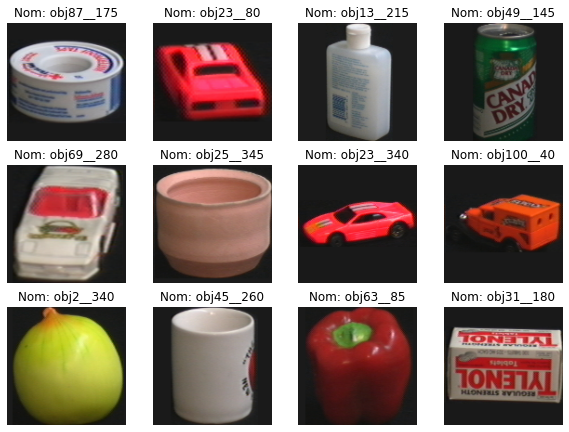

In [103]:
# Affichage de quelques images

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(images.shape[0], size=12)):
    ax = plt.subplot(4, 4, k[0] + 1)
    plt.imshow(images[i])
    plt.title('Nom: {}'.format(nom_images[i]))
    plt.axis("off")

## 2. Calcul des caractéristiques

### 2.1. Calcul des histogrammes

Nous calculons les histogrammes couleurs des différentes images dans les différents espaces de couleur. Pour cela, nous utilisons la fonction *calcul_histogramme(images, histSize=32, histRange=(0, 256), espaceCouleur='RGB')* créé précédemment


In [13]:
# Calcul de l'histogramme dans l'espace RGB
histogrammes_rgb = calcul_histogramme(images, histSize=HIST_SIZE, histRange=HIST_RANGE, espaceCouleur='RGB')

# Calcul de l'histogramme dans l'espace La*b*
histogrammes_lab = calcul_histogramme(images, histSize=HIST_SIZE, histRange=HIST_RANGE, espaceCouleur='Lab')

# Calcul de l'histogramme dans l'espace TSV
histogrammes_tsv = calcul_histogramme(images, histSize=HIST_SIZE, histRange=HIST_RANGE, espaceCouleur='TSV')

### 2.2. Visualisation de quelques histogrammes

####  2.2.1. Histogramme dans l'espace de couleur RGB

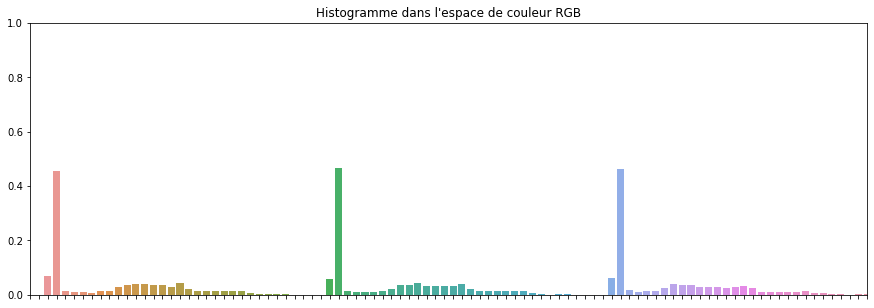

In [18]:
# Affichage de quelques histogrammes

plt.figure(figsize=(15, 5))
for k, i in np.ndenumerate(np.random.randint(histogrammes_rgb.shape[0], size=1)):
    ax = plt.subplot(1, 1, k[0] + 1)
    sns.barplot(x=[i for i in range(len(histogrammes_rgb[i]))], y=np.asarray(histogrammes_rgb[i].reshape(-1)))
    plt.title('Nom: {}'.format(nom_images[i]))
    plt.axis([0, len(histogrammes_rgb[i])-1, 0, 1])
    ax.set_xticklabels([])
    plt.title('Histogramme dans l\'espace de couleur RGB')

####  2.2.2. Histogramme dans l'espace de couleur Lab

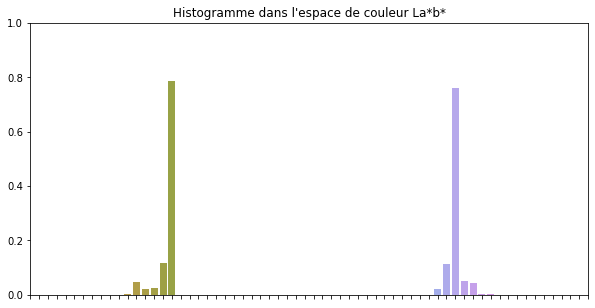

In [20]:
# Affichage de quelques histogrammes

plt.figure(figsize=(10, 5))
for k, i in np.ndenumerate(np.random.randint(histogrammes_lab.shape[0], size=1)):
    ax = plt.subplot(1, 1, k[0] + 1)
    sns.barplot(x=[i for i in range(len(histogrammes_lab[i]))], y=np.asarray(histogrammes_lab[i].reshape(-1)))
    plt.title('Nom: {}'.format(nom_images[i]))
    plt.axis([0, len(histogrammes_lab[i])-1, 0, 1])
    ax.set_xticklabels([])
    plt.title('Histogramme dans l\'espace de couleur La*b*')

####  2.2.3. Histogramme dans l'espace de couleur TSV

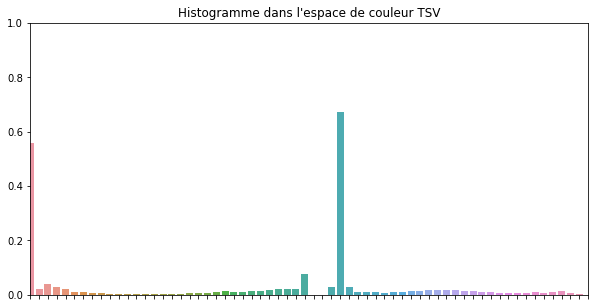

In [21]:
# Affichage de quelques histogrammes

plt.figure(figsize=(10, 5))
for k, i in np.ndenumerate(np.random.randint(histogrammes_tsv.shape[0], size=1)):
    ax = plt.subplot(1, 1, k[0] + 1)
    sns.barplot(x=[i for i in range(len(histogrammes_tsv[i]))], y=np.asarray(histogrammes_tsv[i].reshape(-1)))
    plt.title('Nom: {}'.format(nom_images[i]))
    plt.axis([0, len(histogrammes_tsv[i])-1, 0, 1])
    ax.set_xticklabels([])
    plt.title('Histogramme dans l\'espace de couleur TSV')

### 2.3. Calcul des moments de Hu (descripteur de forme)

Nous calculons les moments de Hu des images de la base de données. Pour cela, nous utilisons la fonction *calcul_hu_moments(images)*

In [23]:
hu_moments = calcul_hu_moments(images)

In [229]:
hu_moments.shape

(7200, 7)

### 2.4. Visualisation des moments de Hu d'une image

In [24]:
print(hu_moments[0])

[ 2.77072428  6.96807038  9.86489308 10.16604817 20.34345377 13.66550735
 20.32118451]


## 3. Sauvegarde des caractéristiques

On commence par stocker toutes les caractéristiques dans un tableau et ensuite on les sauvegardes dans un fichier .npy

In [29]:
# Stockage dans un tableau général
caracteristiquesImages = []
for i in range(len(images)):
    c_g = [nom_images[i], [histogrammes_rgb[i], histogrammes_lab[i], histogrammes_tsv[i]], hu_moments[i]]
    caracteristiquesImages.append(c_g)

# Sauvegarde dans un fichier nomé caractéristiquesImages.npy
np.save('caracteristiquesImages.npy', np.array(caracteristiquesImages, dtype=object))

# III. Evaluation

Notre objectif ici est d'évaluer notre système en fonction des différents paramètres:

1. Evaluation en fonction de l'espace de couleur
2. Evaluation en fonction des poids *w1* et *w2*

Nous allons faire l'éaluation en utilisant seulement la précision sachant que : $precision=\frac{tp}{tp + fp}$ avec :
- tp : True positive (Nombre de résultat pertinent retrouvé)
- fp : False positive (Nombre de résultat non pertinent retrouvé)

## 1. Lecture des caractéristiques

In [25]:
# Lecture des caractéristiques des images
caracteristiquesImages = np.load('caracteristiquesImages.npy', allow_pickle=True)

## 2. Définition des images d'évaluation

Nous alons utilisé 100 images (correspondant aux 100 classes) pour évaluer les différents paramètres

In [30]:
data_evaluation = ['obj{}__0.png'.format(str(i)) for i in range(1, 101)]

## 3. Evaluation des différents paramètres

Nous alons évaluer tous les espaces de couleur, et pour chaque espace, nous allons évaluer différentes valeurs de *w1* et *w2*

In [48]:
espace_couleur = ['RGB', 'Lab', 'TSV']
poids_eval_w1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

final_result = []

for couleur in espace_couleur: # On parcourt tous les espaces de couleur
    for w1 in poids_eval_w1: # On teste différentes valeurs de w1 et w2
        tp = 0 # On initialise le nombre de true positive
        fp = 0 # On initialise le nombre de false positive
        for image_eval in data_evaluation: # Pour toutes les paires de (espace_couleur, w1_w2), on recherche les diférents objets
            # On recupère les K images les plus proches de l'objet en cour
            result = recherche(image_eval, caracteristiquesImages, HIST_SIZE, HIST_RANGE, couleur, w1, 1-w1)
            
            for r in result: # On parcourt chaque objet résultat
                obj_result = caracteristiquesImages[r[0]][0].split('__')[0]
                if image_eval.split('__')[0] == obj_result: # On vérifie s'il s'agit d'un résultat pertinent
                    tp += 1 # Résultat pertinent
                else:
                    fp += 1 # Résultat non pertinent
        
        precision = tp/(tp+fp) # On calcule la précision pour les paires de (espace_couleur, w1_w2)
        f_r = [couleur, '({}, {})'.format(round(w1, 1), round(1-w1, 1)), precision] # On stocke le résultat
        final_result.append(f_r)

## 4. Affichage des résultats d'évaluation

Nous affichons les résultats obtenus pour chaque paire (espace_couleur, w1_w2) évaluées précedement

Text(0.5, 1.0, 'Evaluation des différents paramètres')

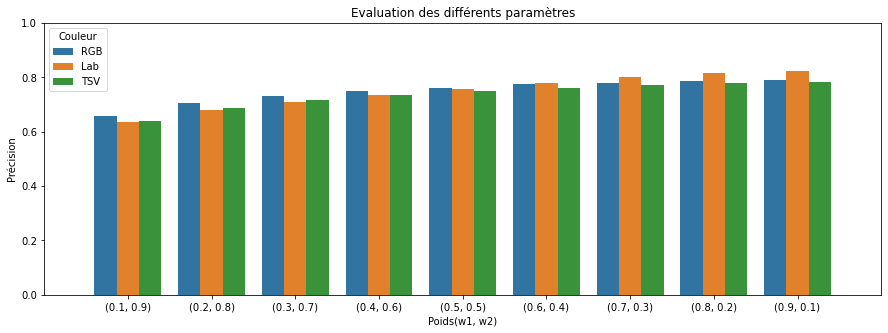

In [64]:
final_result = pd.DataFrame(final_result, columns=['Couleur', 'Poids(w1, w2)', 'Précision'])
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="Poids(w1, w2)", y="Précision", hue="Couleur", data=final_result)
plt.axis([-1, 9, 0, 1])
plt.title('Evaluation des différents paramètres')

Comme nous pouvons le remarquer, les meilleurs résultats sont obtenus avec l'espace de couleur **Lab** et les poids
**w1=0.9** et **w2=0.1** avec une précision d'enirons **80%**


# III. Test du système

L'objectif ici est de faire une recherche à partir d'une image et d'afficher les K résultats les plus proches de l'image d'entrée. Pour cela, nous recupérons le fichier de caractéristisques sauvegardées dans la première partie de notre travail.

Nous utilisons également l'espace de couleur et les poids w1 et w2 ayant donné les meilleurs résultats lors de l'évaluation. Nous avons donc :
- epace_coulelur = Lab
- w1 = 0.9
- w2 = 0.1

## 1. Lecture des caractéristiques

In [11]:
# Lecture des caractéristiques des images
caracteristiquesImages = np.load('caracteristiquesImages.npy', allow_pickle=True)

## 2. Choix de l'image d'entrée et définition des paramètres

Nous alons utiliser ici les meilleurs paramètres trouvés lors de l'évaluation

In [66]:
# Image d'entrée
image_name = "obj100__0.png"

# Paramètres
espace_couleur = 'Lab'
w1 = 0.9
w2 = 0.1

## 3. Recherche des images les plus proches

Nour recherchons les K images les plus pertinentes en utilisant la fonction *recherche()* créée précedement

In [67]:
resultats = recherche(image_name, caracteristiquesImages, HIST_SIZE, HIST_RANGE, espace_couleur, w1, w2)

## 4. Affichage des K premiers résultats

In [70]:
printmd("**Exemple :**", color="blue")

printmd("**&emsp; &emsp; > search : {}**".format(image_name.split('.')[0]))
print()

printmd("**Résultats de recherche (K={}) :**".format(K), color="blue")
printmd("**&emsp; &emsp; Image &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; Distance**".format(image_name.split('.')[0]))

for i in range(K):
    print("\t + {} \t \t {}".format(caracteristiquesImages[resultats[i][0]][0], resultats[i][1]))

<span style='color:blue'><font size='3'>**Exemple :**</font></span>

<span style='color:None'><font size='3'>**&emsp; &emsp; > search : obj100__0**</font></span>

<span style='color:blue'><font size='3'>**Résultats de recherche (K=15) :**</font></span>

<span style='color:None'><font size='3'>**&emsp; &emsp; Image &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; Distance**</font></span>

	 + obj100__0 	 	 0.0
	 + obj100__5 	 	 0.02946210229841028
	 + obj100__350 	 	 0.032033458183277116
	 + obj100__355 	 	 0.04200132910255175
	 + obj100__10 	 	 0.05019686552945886
	 + obj100__345 	 	 0.058974941752039184
	 + obj100__340 	 	 0.07997208869061104
	 + obj100__15 	 	 0.10271201024476223
	 + obj100__335 	 	 0.1073249957755136
	 + obj100__20 	 	 0.13073078814589487
	 + obj100__330 	 	 0.1412724212707269
	 + obj100__25 	 	 0.1439106218463491
	 + obj100__30 	 	 0.16494672666703933
	 + obj100__35 	 	 0.18127972812454446
	 + obj100__40 	 	 0.19261618285120036
